# 2.2. Conformal prediction for regression problems - Python

## Mục lục

- <a href='#1'>1. Xây dựng bài toán và xử lý dữ liệu </a>
- <a href='#2'>2. Conformal Prediction tự cài đặt </a>
    - <a href='#2.1'>2.1. Phương pháp Split </a>
    - <a href='#2.2'>2.2. Phương pháp Jackknife+ </a>
    - <a href='#2.3'>2.3. Phương pháp Jackknife-minimax </a>
- <a href='#3'>3. Conformal Prediction sử dụng thư viện MAPIE</a>
    - <a href='#3.1'>3.1. Phương pháp Split </a>
    - <a href='#3.2'>3.2. Phương pháp Jackknife+ </a>
    - <a href='#3.3'>3.3. Phương pháp Jackknife-minimax </a>
- <a href='#4'>4. Tham khảo</a>

## Nhóm 4:
- Huỳnh Tiến Dũng - 21020007
- Hoàng Văn Nguyên - 21020370
- Vũ Quốc Tuấn - 21020033

## <a id='1'>1. Xây dựng bài toán và xử lý dữ liệu
    
**Yêu cầu**: Sử dụng bộ dữ liệu `ys1a.csv` để thực hiện conformal prediction, trong đó cần phỏng đoán biến `ys` từ các biến `vec`, `delta`, `deltachi`, `deltahmix`, `deltasmix`. Giải thích chi tiết từng bước thực hiện.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Đọc dữ liệu đầu vào `data/ys1a.csv`

In [2]:
ys1a = pd.read_csv('data/ys1a.csv')
print("Shape:", ys1a.shape)
ys1a.head()

Shape: (377, 16)


,composition,vec,deltachi,delta,deltahmix,deltasmix,ref,phase,density,hv,testtype,ys,ysmax,elongation,ym,group
0,CoFeNi,9.000000,0.032998,0.327647,-1.333333,9.134371,4,FCC,8.5,125.0,C,204.0,NaN,NaN,207.0,Al-Co-Cr-Fe-Mn-Ni
1,CoFeNi,9.000000,0.032998,0.327647,-1.333333,9.134371,4,FCC,8.5,125.0,C,209.0,NaN,NaN,207.0,Al-Co-Cr-Fe-Mn-Ni
2,CoFeNi,9.000000,0.032998,0.327647,-1.333333,9.134371,5,FCC,8.5,NaN,T,211.0,513.0,31,207.0,Al-Co-Cr-Fe-Mn-Ni
3,CoFeNiSi0.25,8.615385,0.032490,2.025282,-11.834320,10.686521,4,FCC,7.7,149.0,C,196.0,NaN,NaN,194.0,Al-Co-Cr-Fe-Mn-Ni
4,CoFeNiSi0.5,8.285714,0.031944,2.657710,-19.428571,11.239357,4,FCC+Im,7.1,287.0,C,476.0,NaN,NaN,NaN,Al-Co-Cr-Fe-Mn-Ni


Tiếp đến, ta xem phân bố giá trị của biến `ys`.

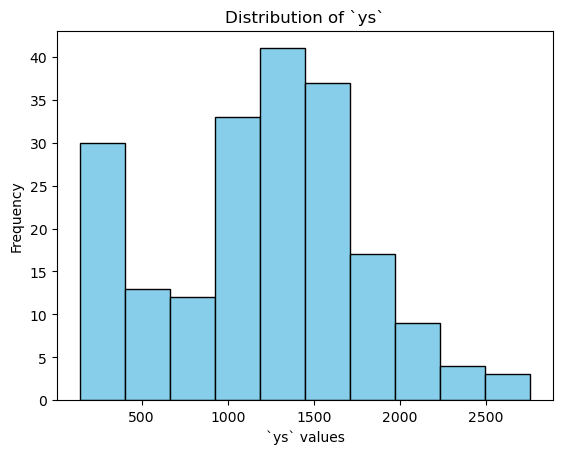

In [3]:
# Plotting histogram
plt.hist(ys1a['ys'], bins=10, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('`ys` values')
plt.ylabel('Frequency')
plt.title('Distribution of `ys`')

# Show plot
plt.show()

Ta sẽ kiểm tra xem biến `ys` có giá trị NaN nào hay không.

In [4]:
# Find NaN values in the 'label' column
nan_values = ys1a['ys'].isna()

# Display rows with NaN values in the 'label' column
ys1a[nan_values].head()

,composition,vec,deltachi,delta,deltahmix,deltasmix,ref,phase,density,hv,testtype,ys,ysmax,elongation,ym,group
10,CoCrFeNi,8.250000,0.096695,0.302116,-3.750000,11.526293,7,FCC,8.2,116.0,NaN,NaN,NaN,NaN,225.0,Al-Co-Cr-Fe-Mn-Ni
11,CoCrFeNi,8.250000,0.096695,0.302116,-3.750000,11.526293,7,FCC,8.2,113.0,NaN,NaN,NaN,NaN,225.0,Al-Co-Cr-Fe-Mn-Ni
12,CoCrFeMo0.5Ni,8.000000,0.140458,2.913949,-4.345679,13.145945,8,FCC+Im,8.5,210.0,NaN,NaN,NaN,NaN,NaN,Al-Co-Cr-Fe-Mn-Ni
18,CoCrFeNiTi,7.400000,0.141506,6.680562,-16.320000,13.381611,9,FCC,7.2,NaN,C,NaN,2020.0,9,135.0,Al-Co-Cr-Fe-Mn-Ni
19,Co1.5CrFeNi1.5Ti0.5,8.090909,0.121866,4.885036,-10.743802,12.859137,10,FCC,7.8,509.0,NaN,NaN,NaN,NaN,211.0,Al-Co-Cr-Fe-Mn-Ni


Trong $377$ dòng dữ liệu có tới $178$ dòng có giá trị `ys` là NaN. Ta sẽ áp dụng cách xử lý đơn giản là xóa các dòng này đi khỏi tập dữ liệu. Dữ liệu còn lại $199$ dòng.

In [5]:
ys1a.dropna(subset=['ys'], inplace=True)
ys1a.head()

,composition,vec,deltachi,delta,deltahmix,deltasmix,ref,phase,density,hv,testtype,ys,ysmax,elongation,ym,group
0,CoFeNi,9.000000,0.032998,0.327647,-1.333333,9.134371,4,FCC,8.5,125.0,C,204.0,NaN,NaN,207.0,Al-Co-Cr-Fe-Mn-Ni
1,CoFeNi,9.000000,0.032998,0.327647,-1.333333,9.134371,4,FCC,8.5,125.0,C,209.0,NaN,NaN,207.0,Al-Co-Cr-Fe-Mn-Ni
2,CoFeNi,9.000000,0.032998,0.327647,-1.333333,9.134371,5,FCC,8.5,NaN,T,211.0,513.0,31,207.0,Al-Co-Cr-Fe-Mn-Ni
3,CoFeNiSi0.25,8.615385,0.032490,2.025282,-11.834320,10.686521,4,FCC,7.7,149.0,C,196.0,NaN,NaN,194.0,Al-Co-Cr-Fe-Mn-Ni
4,CoFeNiSi0.5,8.285714,0.031944,2.657710,-19.428571,11.239357,4,FCC+Im,7.1,287.0,C,476.0,NaN,NaN,NaN,Al-Co-Cr-Fe-Mn-Ni


Ta cần phỏng đoán biến `ys` từ các biến `vec`, `delta`, `deltachi`, `deltahmix`, `deltasmix`. Ta sẽ giữ lại những biến cần thiết và xây dựng dữ liệu tương ứng như sau:

In [6]:
X = ys1a[['vec', 'delta', 'deltachi', 'deltahmix', 'deltasmix']]
y = ys1a['ys']
X[:5], y[:5]

(        vec     delta  deltachi  deltahmix  deltasmix
 0  9.000000  0.327647  0.032998  -1.333333   9.134371
 1  9.000000  0.327647  0.032998  -1.333333   9.134371
 2  9.000000  0.327647  0.032998  -1.333333   9.134371
 3  8.615385  2.025282  0.032490 -11.834320  10.686521
 4  8.285714  2.657710  0.031944 -19.428571  11.239357,
 0    204.0
 1    209.0
 2    211.0
 3    196.0
 4    476.0
 Name: ys, dtype: float64)

Sau đó, ta tách ra thành 3 tập dữ liệu là: tập train (80%), tập calibration (10%) và tập test (10%).

In [7]:
from sklearn.model_selection import train_test_split
seed = 42
# Split the data into training (80%), calibration + test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=seed)

# Split calibration + test into calibration (10%) and test (10%)
X_calibrate, X_test, y_calibrate, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

# Display the shapes of the resulting sets
print("Training set - X:", X_train.shape, " y:", y_train.shape)
print("Calibration set - X:", X_calibrate.shape, " y:", y_calibrate.shape)
print("Test set - X:", X_test.shape, " y:", y_test.shape)

Training set - X: (159, 5)  y: (159,)
Calibration set - X: (20, 5)  y: (20,)
Test set - X: (20, 5)  y: (20,)


Sử dụng mô hình Linear Regression trên tập train. Sau đó, ta thử tính toán các hàm chi phí MSE, R-squared trên 3 tập dữ liệu.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = model.predict(X_train)

# Evaluate the model on the training set
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print("Training set performance:")
print("Mean Squared Error:", mse_train)
print("R-squared:", r2_train)

# Predictions on the calibration set
y_calibrate_pred = model.predict(X_calibrate)

# Evaluate the model on the calibration set
mse_calibrate = mean_squared_error(y_calibrate, y_calibrate_pred)
r2_calibrate = r2_score(y_calibrate, y_calibrate_pred)

print("\nCalibration set performance:")
print("Mean Squared Error:", mse_calibrate)
print("R-squared:", r2_calibrate)

# Predictions on the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\nTest set performance:")
print("Mean Squared Error:", mse_test)
print("R-squared:", r2_test)

Training set performance:
Mean Squared Error: 196987.6888501888
R-squared: 0.46451787296500924

Calibration set performance:
Mean Squared Error: 191572.51916767607
R-squared: -0.45484899717439764

Test set performance:
Mean Squared Error: 195519.67971663835
R-squared: 0.45359844913972713


## <a id='2'>2. Conformal Prediction tự cài đặt

Các phương pháp được đề cập sau đây bao gồm:
- Split
- Jackknife+
- Jackknife-minmax

Ngoài ra, còn nhiều phương pháp khác không được để cập ở đây nhưng được tích hợp trong thư viện MAPIE như CV, CV+, CV-minmax, jackknife+-after-bootstrap, conformalized quantile regression (CQR), ensemble batch prediction intervals (EnbPI)...
    
Nguồn tham khảo: [MAPIE - Theoretical Description Regression](https://mapie.readthedocs.io/en/latest/theoretical_description_regression.html) 

### <a id='2.1'>2.1. Phương pháp Split

Phương pháp Split (chia tập train và tập calibration) tính toán các giá trị dư của một tập calibration để ước lượng sai số điển hình thu được trên một điểm dữ liệu kiểm thử mới. Khoảng dự đoán do đó được xác định bởi dự đoán thu được từ mô hình được huấn luyện trên tập train $\pm$ quantiles của các "conformity score" từ tập calibration:

$$\hat{\mu}(X_{n+1}) \pm ((1-\alpha) \textrm{ quantile của } |Y_1-\hat{\mu}(X_1)|, ..., |Y_n-\hat{\mu}(X_n)|)$$

hay

$$\hat{C}_{n, \alpha}^{\rm split}(X_{n+1}) = \hat{\mu}(X_{n+1}) \pm \hat{q}_{n, \alpha}^+{|Y_i-\hat{\mu}(X_i)|}$$

với $\hat{q}_{n, \alpha}^+$ là $(1-\alpha)$ quantile của phân phối.

Vì phương pháp này chỉ ước lượng "conformity score" trên tập hiệu chuẩn (calibration), nên phải có đủ quan sát để chia tách tập dữ liệu gốc thành tập huấn luyện (train) và tập hiệu chuẩn (calibration) như đã đề cập trong <a href='#4'>[2]</a>. Hơn nữa, phương pháp này luôn đưa ra khoảng dự đoán với độ rộng không đổi.

Sử dụng mô hình lấy kết quả dự đoán trên tập calibration

In [9]:
y_cal_pred = model.predict(X_calibrate)
y_cal_pred

array([1181.10126804, 1121.49574579,  970.55581404, 2017.31602095,
       1994.13194964, 1383.59056049, 1451.8476106 , 2263.33750789,
       1001.81183309, 1182.19543513, 1307.97658679, 1486.83241127,
       1001.81183309, 1458.47570746, 1095.52526321, 1062.20177972,
       1059.73115606,  794.03208905, 1062.20177972, 1061.74397424])

Tính toán sai số giữa nhãn thật và nhãn dự đoán của tập calibration.

In [10]:
y_cal_error = abs(y_cal_pred - y_calibrate)
y_cal_error[:5]

324     236.898732
309      78.504254
27     1062.444186
289     816.316021
285     389.131950
Name: ys, dtype: float64

Tìm quantile tương ứng với $\alpha = 10\%$ trên tập sai số. Tham số `interpolation='higher'` tương ứng với sẽ sử dụng giá trị cao hơn nếu quantile mong muốn nằm giữa hai điểm dữ liệu.

In [11]:
# Calculate 1-alpha quantile from the distribution of absolute errors
alpha = 0.1
quantile = y_cal_error.quantile(q=1-alpha, interpolation='higher')
quantile

816.3160209508228

Sử dụng mô hình lấy kết quả dự đoán trên tập test

In [12]:
y_test_pred = model.predict(X_test)
y_test_pred

array([1379.26648885, 1085.31438228, 1372.83419243, 1235.2434303 ,
       1121.86272009,  496.46702153, 1793.90827493,  537.22286075,
       1010.90816622, 1148.01497576, 1392.00331895, 1332.69496762,
       1140.36997897, 1388.2691506 , 1733.47609702, 1037.94156147,
        252.33572263,  909.31863556, 1310.1042846 , 1180.00206918])

Tính toán khoảng dự đoán dựa trên quantile (khoảng [`y_test_pred - quantile`, `y_test_pred + quantile` ]):
- Khoảng trái `y_test_interval_pred_left = y_test_pred - quantile`
- Khoảng phải `y_test_interval_pred_right = y_test_pred + quantile`

In [13]:
# Calculate prediction interval
y_test_interval_pred_left = y_test_pred - quantile
y_test_interval_pred_right = y_test_pred + quantile
y_test_interval_pred_left, y_test_interval_pred_right

(array([ 562.9504679 ,  268.99836133,  556.51817148,  418.92740935,
         305.54669914, -319.84899942,  977.59225398, -279.0931602 ,
         194.59214527,  331.69895481,  575.687298  ,  516.37894667,
         324.05395802,  571.95312965,  917.16007607,  221.62554052,
        -563.98029832,   93.00261461,  493.78826365,  363.68604823]),
 array([2195.5825098 , 1901.63040323, 2189.15021338, 2051.55945126,
        1938.17874104, 1312.78304249, 2610.22429589, 1353.5388817 ,
        1827.22418717, 1964.33099671, 2208.3193399 , 2149.01098857,
        1956.68599992, 2204.58517155, 2549.79211797, 1854.25758242,
        1068.65174358, 1725.63465651, 2126.42030555, 1996.31809013]))

Tổng hợp và biểu diễn kết quả dưới dạng bảng.

- `real` là giá trị đúng của nhãn trên tập test (`y_test`).
- `coverage[i]` $=1$ nếu giá trị đúng của tập test (`real[i]`) thuộc khoảng dự đoán (từ `y_test_interval_pred_left[i]` cho đến `y_test_interval_pred_right[i]`).

In [14]:
# Summarize the result of conformal prediction on test set
real = y_test.values
coverage = [0]*len(y_test)
for i in range(len(y_test)):
    if (y_test_interval_pred_left[i] <= real[i]) \
        and (real[i] <= y_test_interval_pred_right[i]):
        coverage[i] = 1
result = pd.DataFrame(list(zip(real, y_test_interval_pred_left, y_test_interval_pred_right, y_test_pred, coverage)),
                  columns=['actual', 'lower_interval', 'upper_interval', 'predicted', 'coverage'])
result[:5]

,actual,lower_interval,upper_interval,predicted,coverage
0,1708.0,562.950468,2195.582510,1379.266489,1
1,244.0,268.998361,1901.630403,1085.314382,0
2,1900.0,556.518171,2189.150213,1372.834192,1
3,1058.0,418.927409,2051.559451,1235.243430,1
4,750.0,305.546699,1938.178741,1121.862720,1


Tính toán độ phủ của tập dự đoán của mô hình trên tập test.

In [15]:
print("Coverage rate =", sum(result.coverage)/len(result.coverage))

Coverage rate = 0.9


### <a id='2.2'>2.2. Phương pháp Jackknife+

Phương pháp jackknife+ dựa trên việc xây dựng một tập hợp các mô hình leave-one-out. Việc ước lượng khoảng dự đoán được thực hiện trong ba bước chính:

- Đối với mỗi trường hợp $i = 1, ..., n$ trong tập huấn luyện, chúng ta điều chỉnh hàm hồi quy $\hat{\mu}_{-i}$ trên toàn bộ tập huấn luyện với điểm thứ $i$ bị loại bỏ, tạo ra $n$ mô hình leave-one-out.
- Các leave-one-out "conformity score" tuơng ứng được tính toán cho mỗi điểm thứ $i$ là $R_i^{\rm LOO} = |Y_i - \hat{\mu}_{-i}(X_i)|.$
- Kết quả của khoảng tin cậy có thể được tóm tắt như sau:
$$\hat{C}_{n, \alpha}^{\rm jackknife+}(X_{n+1}) = [ \hat{q}_{n, \alpha}^-\{\hat{\mu}_{-i}(X_{n+1}) - R_i^{\rm LOO} \}, \hat{q}_{n, \alpha}^+\{\hat{\mu}_{-i}(X_{n+1}) + R_i^{\rm LOO} \}]$$

với $\hat{q}_{n, \alpha}^-$ là $\alpha$ quantile và $\hat{q}_{n, \alpha}^+$ là $(1-\alpha)$ quantile của phân phối.

Như mô tả trong <a href='#4'>[1]</a>, phương pháp này đảm bảo một độ ổn định cao hơn với mức bao phủ là $1-2\alpha$ cho một mức bao phủ mục tiêu là $1-\alpha$, mà không có bất kỳ giả định trước nào về phân phối của dữ liệu $(X, Y)$ hay về mô hình dự đoán.

In [16]:
import numpy as np
from sklearn.linear_model import LinearRegression

def fit_jackknife_models(X, Y):
    n = len(X)
    models = []
    loo_predictions = np.zeros(n)
    for i in range(n):
        X_loo, Y_loo = X.drop(index=i), Y.drop(index=i)
        model = LinearRegression().fit(X_loo.values, Y_loo)
        
        loo_predictions[i] = np.abs(Y.iloc[i] - model.predict(X.iloc[i, :].values.reshape(1, -1)))

        models.append(model)

    return models, loo_predictions

def predict_jackknife_plus(models, loo_predictions, X, alpha):
    n = len(models)
    Y_pred = np.zeros((n, len(X)))
    for i, model in enumerate(models):
        Y_pred[i, :] = model.predict(X.values)

    prediction_interval_lower = np.percentile(Y_pred - loo_predictions.reshape(-1, 1), alpha  * 100, axis=0, method='lower')
    prediction_interval_upper = np.percentile(Y_pred + loo_predictions.reshape(-1, 1), (1 - alpha) * 100, axis=0, method='higher')

    return prediction_interval_lower, prediction_interval_upper

alpha = 0.1

# Fit models and calculate leave-one-out predictions
models, loo_predictions = fit_jackknife_models(X_train.reset_index(drop=True), y_train.reset_index(drop=True))

# Predict and get prediction interval
y_test_interval_pred_left, y_test_interval_pred_right = predict_jackknife_plus(models, loo_predictions, X_test.reset_index(drop=True), alpha)
y_test_interval_pred_left, y_test_interval_pred_right

(array([ 603.0145057 ,  308.53234633,  595.42379169,  454.39097155,
         345.88375788, -277.88893851, 1010.17833774, -237.256515  ,
         235.53126522,  369.19449956,  612.72912567,  555.85375271,
         362.35385525,  609.46619779,  953.65849813,  261.90611912,
        -525.54532996,  129.44328248,  535.1203339 ,  401.95710949]),
 array([2148.71315898, 1853.43784678, 2140.32929214, 1999.69520366,
        1890.78925832, 1267.55248878, 2559.77885028, 1307.07826061,
        1780.25523287, 1914.1       , 2157.63462611, 2102.12138585,
        1907.25935569, 2154.37169823, 2504.17472326, 1813.13249998,
        1023.52045864, 1677.093336  , 2080.02583434, 1950.33149203]))

Tổng hợp và biểu diễn kết quả dưới dạng bảng.

- `real` là giá trị đúng của nhãn trên tập test (`y_test`).
- `coverage[i]` $=1$ nếu giá trị đúng của tập test (`real[i]`) thuộc khoảng dự đoán (từ `y_test_interval_pred_left[i]` cho đến `y_test_interval_pred_right[i]`).

In [17]:
# Summarize the result of conformal prediction on test set
real = y_test.values
coverage = [0]*len(y_test)
for i in range(len(y_test)):
    if (y_test_interval_pred_left[i] <= real[i]) \
        and (real[i] <= y_test_interval_pred_right[i]):
        coverage[i] = 1
result = pd.DataFrame(list(zip(real, y_test_interval_pred_left, y_test_interval_pred_right, y_test_pred, coverage)),
                  columns=['actual', 'lower_interval', 'upper_interval', 'predicted', 'coverage'])
result[:5]

,actual,lower_interval,upper_interval,predicted,coverage
0,1708.0,603.014506,2148.713159,1379.266489,1
1,244.0,308.532346,1853.437847,1085.314382,0
2,1900.0,595.423792,2140.329292,1372.834192,1
3,1058.0,454.390972,1999.695204,1235.243430,1
4,750.0,345.883758,1890.789258,1121.862720,1


Tính toán độ phủ của tập dự đoán của mô hình trên tập test.

In [18]:
print("Coverage rate =", sum(result.coverage)/len(result.coverage))

Coverage rate = 0.9


### <a id='2.3'>2.3. Phương pháp Jackknife-minmax

Phương pháp jackknife-minmax mang lại một lựa chọn ít đảm bảo hơn một chút vì nó sử dụng các giá trị tối thiểu và tối đa của các dự đoán leave-one-out để tính toán khoảng dự đoán. Các khoảng dự đoán ước lượng có thể được định nghĩa như sau:

$$\hat{C}_{n, \alpha}^{\rm jackknife-mm}(X_{n+1}) = [\min \hat{\mu}_{-i}(X_{n+1}) - \hat{q}_{n, \alpha}^+\{R_I^{\rm LOO} \}, \max \hat{\mu}_{-i}(X_{n+1}) + \hat{q}_{n, \alpha}^+\{R_I^{\rm LOO} \}]$$

Như được chứng minh bởi <a href='#4'>[1]</a>, phương pháp này đảm bảo mức bao phủ là $1-\alpha$ cho một mức bao phủ mục tiêu là $1-\alpha$.

In [19]:
import numpy as np
from sklearn.linear_model import LinearRegression

def fit_jackknife_models(X, Y, alpha):
    n = len(X)
    models = []
    loo_predictions = np.zeros(n)

    for i in range(n):
        X_loo, Y_loo = X.drop(index=i), Y.drop(index=i)
        model = LinearRegression().fit(X_loo.values, Y_loo)
        
        # Reshape X[i, :] to make it 2D before prediction
        loo_predictions[i] = np.abs(Y.iloc[i] - model.predict(X.iloc[i, :].values.reshape(1, -1)))

        models.append(model)

    quantile_value = np.percentile(loo_predictions, (1 - alpha) * 100, method='higher')

    return models, quantile_value

def predict_jackknife_minmax(models, quantile_value, X, alpha):
    n = len(models)
    Y_pred = np.zeros((n, len(X)))
    
    for i, model in enumerate(models):
        Y_pred[i, :] = model.predict(X.values)

    min_values = np.min(Y_pred, axis=0) - quantile_value
    max_values = np.max(Y_pred, axis=0) + quantile_value

    return min_values, max_values

alpha = 0.1

# Fit models and calculate leave-one-out predictions
models, quantile_value = fit_jackknife_models(X_train.reset_index(drop=True), y_train.reset_index(drop=True), alpha)

# Predict and get prediction interval using jackknife-minmax method
y_test_interval_pred_left, y_test_interval_pred_right = predict_jackknife_minmax(models, quantile_value, X_test.reset_index(drop=True), alpha)
y_test_interval_pred_left, y_test_interval_pred_right

(array([ 595.40468289,  292.68622671,  577.88567159,  428.00781857,
         324.4238697 , -288.13241873, 1004.36283751, -281.9373881 ,
         217.07971174,  365.62214371,  587.16551162,  547.51602897,
         352.94323788,  596.29131047,  940.8003044 ,  246.68208597,
        -552.82761018,  125.3163035 ,  511.08821026,  391.4603147 ]),
 array([2177.56917673, 1873.13749538, 2158.5355551 , 2069.85607791,
        1911.97374904, 1280.15564247, 2602.06854299, 1326.49174844,
        1799.27610919, 1938.0548635 , 2225.45039393, 2135.58973182,
        1922.53104847, 2181.79066543, 2525.99218532, 1850.43105965,
        1038.39359322, 1709.19390081, 2101.40008378, 1987.03574646]))

Tổng hợp và biểu diễn kết quả dưới dạng bảng.

- `real` là giá trị đúng của nhãn trên tập test (`y_test`).
- `coverage[i]` $=1$ nếu giá trị đúng của tập test (`real[i]`) thuộc khoảng dự đoán (từ `y_test_interval_pred_left[i]` cho đến `y_test_interval_pred_right[i]`).

In [20]:
# Summarize the result of conformal prediction on test set
real = y_test.values
coverage = [0]*len(y_test)
for i in range(len(y_test)):
    if (y_test_interval_pred_left[i] <= real[i]) \
        and (real[i] <= y_test_interval_pred_right[i]):
        coverage[i] = 1
result = pd.DataFrame(list(zip(real, y_test_interval_pred_left, y_test_interval_pred_right, y_test_pred, coverage)),
                  columns=['actual', 'lower_interval', 'upper_interval', 'predicted', 'coverage'])
result[:5]

,actual,lower_interval,upper_interval,predicted,coverage
0,1708.0,595.404683,2177.569177,1379.266489,1
1,244.0,292.686227,1873.137495,1085.314382,0
2,1900.0,577.885672,2158.535555,1372.834192,1
3,1058.0,428.007819,2069.856078,1235.243430,1
4,750.0,324.423870,1911.973749,1121.862720,1


Tính toán độ phủ của tập dự đoán của mô hình trên tập test.

In [21]:
print("Coverage rate =", sum(result.coverage)/len(result.coverage))

Coverage rate = 0.9


## <a id='3'>3. Conformal Prediction sử dụng thư viện MAPIE

### <a id='3.1'>3.1. Phương pháp Split

Sử dụng `model` đã xây dựng ở trên, ta sử dụng thư viện MAPIE để thực hiện conformal prediction. Phương pháp Split có tên là `method="base"` trong MAPIE.

Sử dụng cùng $\alpha=0.1$, ta fit mô hình MAPIE với tập calibrate và dự đoán trên tập test để nhận được `y_pis` (chính là `y_test_interval_pred_left` và `y_test_interval_pred_right` đã được tính ở phần trước). 

In [22]:
from mapie.regression import MapieRegressor

mapie_regressor = MapieRegressor(model, cv="prefit", method="base")
mapie_regressor.fit(X_calibrate, y_calibrate)

alpha = 0.1
y_test_pred, y_pis = mapie_regressor.predict(X_test, alpha=alpha)
y_pis = np.squeeze(y_pis)
y_test_interval_pred_left = y_pis[:, 0]
y_test_interval_pred_right = y_pis[:, 1]
y_test_interval_pred_left, y_test_interval_pred_right

(array([ 562.9504679 ,  268.99836133,  556.51817148,  418.92740935,
         305.54669914, -319.84899942,  977.59225398, -279.0931602 ,
         194.59214527,  331.69895481,  575.687298  ,  516.37894667,
         324.05395802,  571.95312965,  917.16007607,  221.62554052,
        -563.98029832,   93.00261461,  493.78826365,  363.68604823]),
 array([2195.5825098 , 1901.63040323, 2189.15021338, 2051.55945126,
        1938.17874104, 1312.78304249, 2610.22429589, 1353.5388817 ,
        1827.22418717, 1964.33099671, 2208.3193399 , 2149.01098857,
        1956.68599992, 2204.58517155, 2549.79211797, 1854.25758242,
        1068.65174358, 1725.63465651, 2126.42030555, 1996.31809013]))

Tương tự như phần trước, ta tổng hợp và biểu diễn kết quả dưới dạng bảng.

- `real` là giá trị đúng của nhãn trên tập test (`y_test`).
- `coverage[i]` $=1$ nếu giá trị đúng của tập test (`real[i]`) thuộc khoảng dự đoán (từ `y_test_interval_pred_left[i]` cho đến `y_test_interval_pred_right[i]`).

In [23]:
# Summarize the result of conformal prediction on test set
real = y_test.values
coverage = [0]*len(y_test)
for i in range(len(y_test)):
    if (y_test_interval_pred_left[i] <= real[i]) \
        and (real[i] <= y_test_interval_pred_right[i]):
        coverage[i] = 1
result = pd.DataFrame(list(zip(real, y_test_interval_pred_left, y_test_interval_pred_right, y_test_pred, coverage)),
                  columns=['actual', 'lower_interval', 'upper_interval', 'predicted', 'coverage'])
result[:5]

,actual,lower_interval,upper_interval,predicted,coverage
0,1708.0,562.950468,2195.582510,1379.266489,1
1,244.0,268.998361,1901.630403,1085.314382,0
2,1900.0,556.518171,2189.150213,1372.834192,1
3,1058.0,418.927409,2051.559451,1235.243430,1
4,750.0,305.546699,1938.178741,1121.862720,1


Độ phủ coverage rate tính được sử dụng thư viện MAPIE bằng với phương pháp tự cài đặt ở trên.

In [24]:
from mapie.metrics import regression_coverage_score_v2

coverage_scores = regression_coverage_score_v2(y_test, y_pis)
print("Coverage rate =", coverage_scores)

Coverage rate = [0.9]


### <a id='3.2'>3.2. Phương pháp Jackknife+

In [25]:
from mapie.regression import MapieRegressor
from sklearn.model_selection import LeaveOneOut

mapie_regressor = MapieRegressor(model, cv=LeaveOneOut(), method="plus")
mapie_regressor.fit(X_train, y_train)

alpha = 0.1
y_test_pred, y_pis = mapie_regressor.predict(X_test, alpha=alpha)
y_pis = np.squeeze(y_pis)
y_test_interval_pred_left = y_pis[:, 0]
y_test_interval_pred_right = y_pis[:, 1]
y_test_interval_pred_left, y_test_interval_pred_right

(array([ 603.0145057 ,  308.53234633,  595.42379169,  454.39097155,
         345.88375788, -277.88893851, 1010.17833774, -237.256515  ,
         235.53126522,  369.19449956,  612.72912567,  555.85375271,
         362.35385525,  609.46619779,  953.65849813,  261.90611912,
        -525.54532996,  129.44328248,  535.1203339 ,  401.95710949]),
 array([2148.71315898, 1853.43784678, 2140.32929214, 1999.69520366,
        1890.78925832, 1267.55248878, 2559.77885028, 1307.07826061,
        1780.25523287, 1914.1       , 2157.63462611, 2102.12138585,
        1907.25935569, 2154.37169823, 2504.17472326, 1813.13249998,
        1023.52045864, 1677.093336  , 2080.02583434, 1950.33149203]))

Tương tự như phần trước, ta tổng hợp và biểu diễn kết quả dưới dạng bảng.

- `real` là giá trị đúng của nhãn trên tập test (`y_test`).
- `coverage[i]` $=1$ nếu giá trị đúng của tập test (`real[i]`) thuộc khoảng dự đoán (từ `y_test_interval_pred_left[i]` cho đến `y_test_interval_pred_right[i]`).

In [26]:
# Summarize the result of conformal prediction on test set
real = y_test.values
coverage = [0]*len(y_test)
for i in range(len(y_test)):
    if (y_test_interval_pred_left[i] <= real[i]) \
        and (real[i] <= y_test_interval_pred_right[i]):
        coverage[i] = 1
result = pd.DataFrame(list(zip(real, y_test_interval_pred_left, y_test_interval_pred_right, y_test_pred, coverage)),
                  columns=['actual', 'lower_interval', 'upper_interval', 'predicted', 'coverage'])
result[:5]

,actual,lower_interval,upper_interval,predicted,coverage
0,1708.0,603.014506,2148.713159,1379.266489,1
1,244.0,308.532346,1853.437847,1085.314382,0
2,1900.0,595.423792,2140.329292,1372.834192,1
3,1058.0,454.390972,1999.695204,1235.243430,1
4,750.0,345.883758,1890.789258,1121.862720,1


Độ phủ coverage rate tính được sử dụng thư viện MAPIE bằng với phương pháp tự cài đặt ở trên.

In [27]:
from mapie.metrics import regression_coverage_score_v2

coverage_scores = regression_coverage_score_v2(y_test, y_pis)
print("Coverage rate =", coverage_scores)

Coverage rate = [0.9]


### <a id='3.3'>3.3. Phương pháp Jackknife-minmax

In [28]:
from mapie.regression import MapieRegressor
from sklearn.model_selection import LeaveOneOut

mapie_regressor = MapieRegressor(model, cv=LeaveOneOut(), method="minmax")
mapie_regressor.fit(X_train, y_train)

alpha = 0.1
y_test_pred, y_pis = mapie_regressor.predict(X_test, alpha=alpha)
y_pis = np.squeeze(y_pis)
y_test_interval_pred_left = y_pis[:, 0]
y_test_interval_pred_right = y_pis[:, 1]
y_test_interval_pred_left, y_test_interval_pred_right

(array([ 595.40468289,  292.68622671,  577.88567159,  428.00781857,
         324.4238697 , -288.13241873, 1004.36283751, -281.9373881 ,
         217.07971174,  365.62214371,  587.16551162,  547.51602897,
         352.94323788,  596.29131047,  940.8003044 ,  246.68208597,
        -552.82761018,  125.3163035 ,  511.08821026,  391.4603147 ]),
 array([2177.56917673, 1873.13749538, 2158.5355551 , 2069.85607791,
        1911.97374904, 1280.15564247, 2602.06854299, 1326.49174844,
        1799.27610919, 1938.0548635 , 2225.45039393, 2135.58973182,
        1922.53104847, 2181.79066543, 2525.99218532, 1850.43105965,
        1038.39359322, 1709.19390081, 2101.40008378, 1987.03574646]))

Tương tự như phần trước, ta tổng hợp và biểu diễn kết quả dưới dạng bảng.

- `real` là giá trị đúng của nhãn trên tập test (`y_test`).
- `coverage[i]` $=1$ nếu giá trị đúng của tập test (`real[i]`) thuộc khoảng dự đoán (từ `y_test_interval_pred_left[i]` cho đến `y_test_interval_pred_right[i]`).

In [29]:
# Summarize the result of conformal prediction on test set
real = y_test.values
coverage = [0]*len(y_test)
for i in range(len(y_test)):
    if (y_test_interval_pred_left[i] <= real[i]) \
        and (real[i] <= y_test_interval_pred_right[i]):
        coverage[i] = 1
result = pd.DataFrame(list(zip(real, y_test_interval_pred_left, y_test_interval_pred_right, y_test_pred, coverage)),
                  columns=['actual', 'lower_interval', 'upper_interval', 'predicted', 'coverage'])
result[:5]

,actual,lower_interval,upper_interval,predicted,coverage
0,1708.0,595.404683,2177.569177,1379.266489,1
1,244.0,292.686227,1873.137495,1085.314382,0
2,1900.0,577.885672,2158.535555,1372.834192,1
3,1058.0,428.007819,2069.856078,1235.243430,1
4,750.0,324.423870,1911.973749,1121.862720,1


Độ phủ coverage rate tính được sử dụng thư viện MAPIE bằng với phương pháp tự cài đặt ở trên.

In [30]:
from mapie.metrics import regression_coverage_score_v2

coverage_scores = regression_coverage_score_v2(y_test, y_pis)
print("Coverage rate =", coverage_scores)

Coverage rate = [0.9]


## <a id='4'>4. Tham khảo
    
- [MAPIE - Theoretical Description Regression](https://mapie.readthedocs.io/en/latest/theoretical_description_regression.html)
- [1] Rina Foygel Barber, Emmanuel J. Candès, Aaditya Ramdas, and Ryan J. Tibshirani. “Predictive inference with the jackknife+.” Ann. Statist., 49(1):486–507, February 2021.
- [2] Jing Lei, Max G’Sell, Alessandro Rinaldo, Ryan J Tibshirani, and Larry Wasserman. “Distribution-free predictive inference for regression”. Journal of the American Statistical Association, 113(523):1094–1111, 2018.